## Final Project - Caltech 101

1.   Using EfficentB0 to extract rich features
2.   Using dense neural network to clasify our classes

In [1]:
import keras
import matplotlib
from tensorflow.keras.applications import EfficientNetB0
import numpy as np
from keras.preprocessing import image
import random
import os
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

This code is going to run on google colab, so please upload caltech 101 to
content/drive/MyDrive, then run following code

In [2]:
!tar -xzf /content/drive/MyDrive/101_ObjectCategories.tar.gz
!ls

101_ObjectCategories  drive  sample_data





1.   Load Caltech 101 dataset
2.   Use to_categorical method to change data labels to one-hot form

Note: For EfficientNetB0 input data should range [0, 255]. Normalization is included as part of the model, so our data without preprossening is already range [0, 255]



In [3]:
root = '101_ObjectCategories'
exclude = ['BACKGROUND_Google']
categories = []

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]

def get_image(path):
    img = image.load_img(path, target_size = (200, 200, 3))
    img = image.img_to_array(img)
    return img

number_of_samples = 30
train_data = []
test_data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for i, img_path in enumerate(images):
        img = get_image(img_path)
        if i < number_of_samples:
            train_data.append({'x':np.array(img), 'y':c})
        else:
            test_data.append({'x':np.array(img), 'y':c})

x_train = []
y_train = []
x_test = []
y_test = []

x_train = np.array([t["x"] for t in train_data])
y_train = np.array([t["y"] for t in train_data])
x_test = np.array([t["x"] for t in test_data])
y_test = np.array([t["y"] for t in test_data])

num_classes = len(categories)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print("train / test split: %d, %d"%(len(x_train), len(x_test)))
print("training data shape: ", x_train.shape)
print("test data shape: ", x_test.shape)
print("training labels shape: ", y_train.shape)

train / test split: 3030, 5647
training data shape:  (3030, 200, 200, 3)
test data shape:  (5647, 200, 200, 3)
training labels shape:  (3030, 101)


Apply the augmentation on training data

In [8]:
train_datagen = ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.5,
        horizontal_flip=True,
        fill_mode='nearest')

train_datagen.fit(x_train)

test_datagen = ImageDataGenerator()
test_datagen.fit(x_test)

Download and set EfficientNetB0 as pretrain networks

1.   We set include_top = false for both models becuase we want to those for feature extacting
2.   We consider Imagenet as an initial weight

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, UpSampling2D, GlobalAveragePooling2D, Flatten, Concatenate
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

efficient_model = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=None, input_shape=(200, 200, 3))

for layer in efficient_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else: 
        layer.trainable = False

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 101)               2

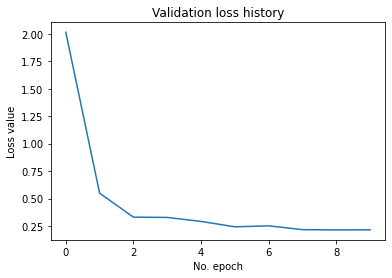

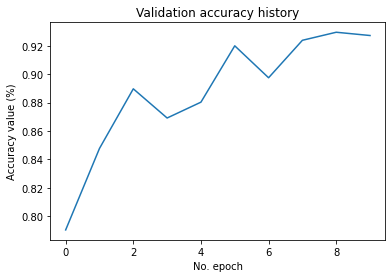

In [10]:
# Model configuration
batch_size = 32
loss_function = categorical_crossentropy
num_classes = 101

eff_model = Sequential()
eff_model.add(efficient_model)
eff_model.add(GlobalAveragePooling2D())
eff_model.add(Dense(512, activation='relu'))
eff_model.add(Dropout(.5))
eff_model.add(Dense(256, activation='relu'))
eff_model.add(Dropout(.5))
eff_model.add(Dense(num_classes, activation='softmax'))

# Compile the model
eff_model.compile(loss=loss_function,
                  optimizer=Adam(),
                  metrics=['accuracy'])

eff_model.summary()

history = eff_model.fit(
              train_datagen.flow(x_train,y_train, batch_size=32),
              epochs = 10,
              verbose = 1,
              batch_size = batch_size,
              validation_data = test_datagen.flow(x_test, y_test, batch_size=32)
            )

# Generate generalization metrics
score = eff_model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {0} / Test accuracy: {1}'.format(score[0], score[1]))

# Visualize history
# Plot history: Loss
plt.plot(history.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()